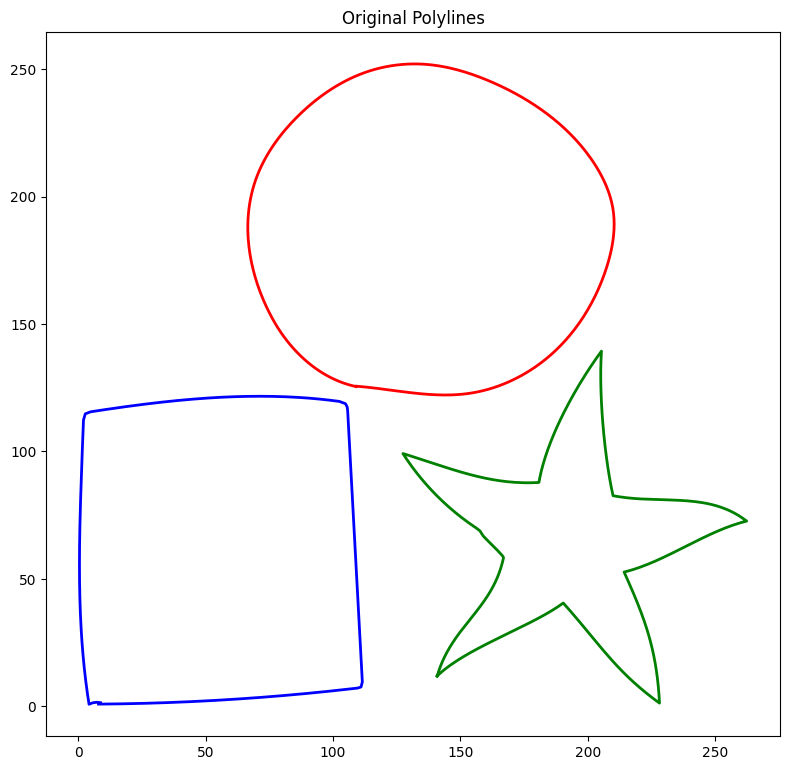

Shape not identified or regularization not implemented
Shape not identified or regularization not implemented
Shape not identified or regularization not implemented


<ipython-input-9-53daebb8cb0e>:18: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


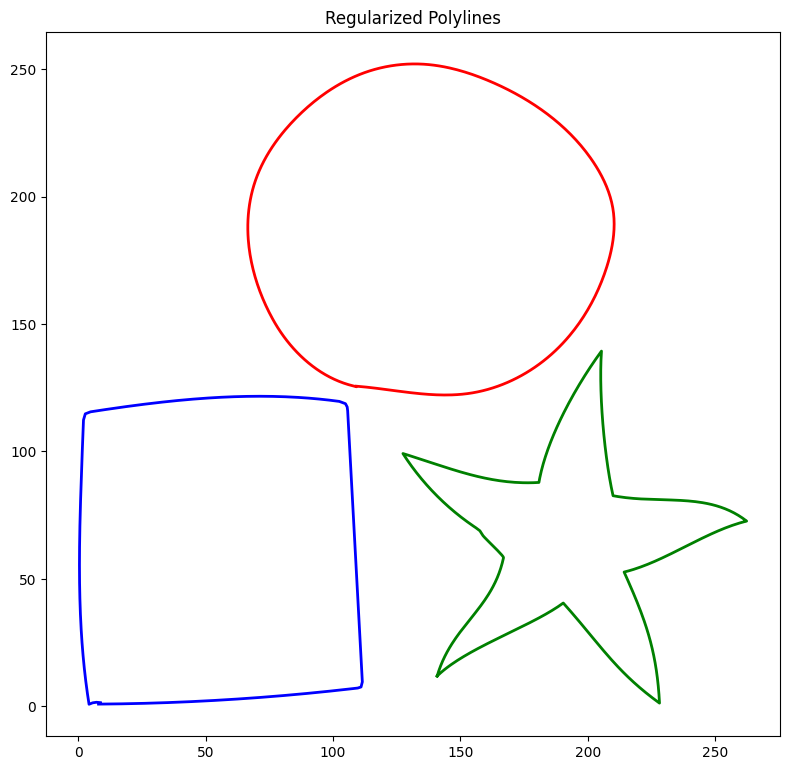

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate lengths between consecutive points in a polyline
def calculate_lengths(polyline):
    lengths = []
    for i in range(len(polyline) - 1):
        length = np.linalg.norm(np.array(polyline[i+1]) - np.array(polyline[i]))
        lengths.append(length)
    return lengths

# Function to calculate angles between consecutive segments in a polyline
def calculate_angles(polyline):
    angles = []
    for i in range(1, len(polyline) - 1):
        v1 = np.array(polyline[i]) - np.array(polyline[i-1])
        v2 = np.array(polyline[i+1]) - np.array(polyline[i])
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(angle)
    return angles

# Function to check if lengths are nearly equal (for square identification)
def check_lengths(lengths, tolerance=0.1):
    mean_length = np.mean(lengths)
    return all(abs(length - mean_length) < tolerance for length in lengths)

# Function to check if angles are close to 90 degrees (for square or rectangle identification)
def check_angles(angles, target_angle=np.pi / 2, tolerance=np.pi / 18):
    return all(abs(angle - target_angle) < tolerance for angle in angles)

# Function to regularize a square shape
def regularize_square(polyline):
    center = np.mean(polyline, axis=0)
    length = np.mean(calculate_lengths(polyline))

    # Define regular square points
    regular_square = np.array([
        center + [length/2, length/2],
        center + [-length/2, length/2],
        center + [-length/2, -length/2],
        center + [length/2, -length/2],
        center + [length/2, length/2]  # Close the loop
    ])
    return regular_square

# Function to regularize a rectangle shape
def regularize_rectangle(polyline):
    center = np.mean(polyline, axis=0)
    lengths = calculate_lengths(polyline)

    # Average width and height based on opposing side lengths
    width = np.mean([lengths[0], lengths[2]])
    height = np.mean([lengths[1], lengths[3]])

    regular_rectangle = np.array([
        center + [width/2, height/2],
        center + [-width/2, height/2],
        center + [-width/2, -height/2],
        center + [width/2, -height/2],
        center + [width/2, height/2]  # Close the loop
    ])
    return regular_rectangle

# Function to regularize a star shape
def regularize_star(polyline):
    center = np.mean(polyline, axis=0)
    radii = [np.linalg.norm(np.array(point) - center) for point in polyline]
    mean_radius = np.mean(radii)

    angles = np.linspace(0, 2 * np.pi, len(polyline))
    regular_star = np.array([
        [center[0] + mean_radius * np.cos(angle), center[1] + mean_radius * np.sin(angle)]
        for angle in angles
    ])
    return regular_star

# Function to identify and regularize shapes
def identify_and_regularize(polyline):
    lengths = calculate_lengths(polyline)
    angles = calculate_angles(polyline)

    if len(polyline) == 5 and np.mean(lengths) < np.mean(angles) * 10:  # Simple heuristic for stars
        print("Regular shape identified: Star")
        return regularize_star(polyline)
    elif check_lengths(lengths) and check_angles(angles):
        if len(polyline) == 5:  # A square with 4 sides and one repeated point
            print("Regular shape identified: Square")
            return regularize_square(polyline)
        else:
            print("Regular shape identified: Rectangle")
            return regularize_rectangle(polyline)
    else:
        print("Shape not identified or regularization not implemented")
        return polyline

# Function to read CSV file and convert to list of polylines
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

# Function to plot polylines
def plot_polylines(polylines, title="Polylines"):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for i, polyline in enumerate(polylines):
        color = colors[i % len(colors)]
        for path in polyline:
            ax.plot(path[:, 0], path[:, 1], c=color, linewidth=2)

    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

# Function to merge close polylines (you may adjust the threshold for your data)
def merge_polylines(polylines, threshold=1.0):
    merged_polylines = []

    for polyline in polylines:
        if not merged_polylines:
            merged_polylines.append(polyline)
        else:
            merged = False
            for i, m_polyline in enumerate(merged_polylines):
                if np.linalg.norm(m_polyline[-1][-1] - polyline[0][0]) < threshold:
                    merged_polylines[i] = np.concatenate((m_polyline, polyline), axis=0)
                    merged = True
                    break
            if not merged:
                merged_polylines.append(polyline)

    return merged_polylines

# Example path (polyline) data
csv_path = '/content/isolated.csv'  # Ensure this file is in the correct location
path_XYs = read_csv(csv_path)

# Merge polylines if needed (adjust the threshold based on your specific data)
merged_polylines = merge_polylines(path_XYs, threshold=1.0)

# Plot the original polylines
plot_polylines(merged_polylines, title="Original Polylines")

# Regularize and plot the polylines
regularized_polylines = []
for polyline in merged_polylines:
    for path in polyline:
        regularized_polyline = identify_and_regularize(path)
        regularized_polylines.append([regularized_polyline])

plot_polylines(regularized_polylines, title="Regularized Polylines")
